### Написать функцию для подсчета retention по дням от даты регистрации игрока

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
from   operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from   datetime import timedelta
from   statsmodels.stats.proportion import proportions_ztest
from   scipy import stats
import scipy.stats as sps

In [2]:
# загружаем датафреймы чтобы посмотреть с какими данными имеем дело
registration = pd.read_csv('shared/problem1-reg_data.csv', sep=';')
enter        = pd.read_csv('shared/problem1-auth_data.csv', sep=';')

In [3]:
# переводим дату регистрации и время захода из UNIX в саму дату, где unit='s' - секунды
registration['reg_ts'] = pd.to_datetime(registration['reg_ts'], unit='s')
enter['auth_ts']       = pd.to_datetime(enter['auth_ts'], unit='s')

In [4]:
registration.tail()

,reg_ts,uid
999995,2020-09-23 15:13:54,1110618
999996,2020-09-23 15:14:46,1110619
999997,2020-09-23 15:15:39,1110620
999998,2020-09-23 15:16:31,1110621
999999,2020-09-23 15:17:24,1110622


In [5]:
enter.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [6]:
registration.shape

(1000000, 2)

In [7]:
enter.shape

(9601013, 2)

In [8]:
registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [9]:
enter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


## Данные проверили, посмотрели исходники, теперь в процессе написания функции проблем не возникнет, также уже знаем, что нужно учесть ';' при чтении данных и перевести дату из UNIX в datetime

In [10]:
# Напишем функцию retention:
def retention(registration, enter, first_date, n):
    # читаем данные
    registration = pd.read_csv(registration, sep = ';')
    enter        = pd.read_csv(enter, sep = ';')
    
    # переводим дату регистрации и время захода из UNIX в саму дату, где unit='s' - секунды
    registration['reg_ts'] = pd.to_datetime(registration['reg_ts'], unit = 's')
    enter['auth_ts']       = pd.to_datetime(enter['auth_ts'], unit = 's')
    
    # объединим два исходных датафрейма по входящим игрокам и добавим им их дату регистрации
    merged = enter.merge(registration, how = 'left', on = 'uid')
    
    # получим временной интервал, по которому будем оценивать retention
    first_date = pd.to_datetime(first_date)
    last_date  = pd.to_datetime(first_date) + pd.Timedelta(days = n)
    
    # получаем необходимый для нас период, 
    # фильтруем по auth_ts, так как дата регистрации = 1 день захода в приложение
    need_period = merged.query('auth_ts <= @last_date and auth_ts >= @first_date')
    
    # создаем колонки по каждому дню захода, по регистрации (первому дню захода) и определяем разницу между ними в днях
    need_period_copy = need_period.copy() # скопируем датафрейм чтоб не возникли ошибки
    
    need_period_copy['enter_day']      = need_period_copy['auth_ts'].dt.to_period('D')
    need_period_copy['first_day']      = need_period_copy.groupby('uid')['auth_ts'].transform('min').dt.to_period('D')
    need_period_copy['period_num_day'] = np.floor((need_period_copy.enter_day - need_period_copy.first_day).apply(attrgetter('n')))
    
    # создаем когорту по нужному периоду с уникальным количеством пользователей на эту когорту
    need_period_cohort = need_period_copy.groupby(['first_day', 'period_num_day']).agg(n_users = ('uid','nunique')).reset_index()
    
    # делаем pivot таблицу в индексе - когорта, колонки - периоды, в значениях - уникальное количество пользователей
    cohort_pivot = need_period_cohort.pivot_table(index = 'first_day', columns = 'period_num_day', values = 'n_users')
          
    # получаем таблицу retention по заданному нами периоду
    cohort_size      = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    return retention_matrix

In [11]:
# дополнительная функция для визуальной обработки нашего среза
def retention_styled(retention):    
    cohort_retention_styled = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Greens')       # раскрашиваем ячейки по столбцам
            .highlight_null('white')                  # делаем белый фон для значений NaN
            .format("{:.02%}", na_rep=""))            # числа форматируем как проценты, 0 заменяем на пустоту

    return cohort_retention_styled

### Необходимо добавить пояснение, так как в функцию retention мы передаем 4 параметра, то:
* registration - путь файла с данными о регистрации пользователей
* enter - путь файла с данными, когда пользователи заходили в приложение
* first_date - дата с которой начиаем расчет retention
* n - число дней для расчета retention

In [12]:
# например, посчитаем 15 дневный retention с 6 октября 2020 года
registration = 'shared/problem1-reg_data.csv'
enter        = 'shared/problem1-auth_data.csv'
first_date   = '2019-09-01'
n            = 30

retention_styled(retention(registration, enter, first_date, n))

period_num_day,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
first_day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-01,100.00%,6.98%,15.75%,17.43%,19.39%,23.92%,26.59%,23.86%,19.97%,21.05%,22.03%,22.51%,21.14%,21.82%,21.57%,21.08%,21.63%,20.87%,20.55%,20.57%,20.85%,20.99%,20.59%,21.19%,20.37%,20.16%,20.68%,20.40%,19.92%,21.06%
2019-09-02,100.00%,7.77%,15.43%,17.00%,20.27%,22.92%,26.86%,22.55%,19.78%,21.32%,21.57%,21.94%,22.13%,21.87%,19.93%,21.66%,21.23%,20.71%,20.75%,21.14%,20.89%,20.59%,20.42%,20.21%,20.29%,20.36%,20.34%,20.66%,19.69%,
2019-09-03,100.00%,7.74%,14.38%,16.80%,19.25%,22.60%,26.80%,21.75%,19.66%,21.05%,20.62%,22.23%,21.25%,21.37%,20.26%,20.57%,20.52%,20.51%,21.55%,20.55%,19.98%,19.95%,20.09%,20.11%,20.51%,19.65%,19.82%,19.78%,,
2019-09-04,100.00%,7.45%,13.88%,16.23%,19.29%,21.54%,25.95%,21.80%,19.17%,20.56%,19.64%,21.61%,21.31%,20.79%,19.29%,20.75%,19.91%,19.38%,19.89%,20.08%,20.02%,19.94%,19.70%,18.37%,20.34%,19.34%,19.12%,,,
2019-09-05,100.00%,7.24%,12.91%,17.34%,17.49%,22.12%,24.21%,20.58%,18.08%,18.38%,19.36%,19.61%,20.28%,18.51%,19.61%,18.92%,18.64%,20.40%,17.59%,19.64%,18.13%,18.79%,18.33%,18.38%,18.28%,18.90%,,,,
2019-09-06,100.00%,7.13%,13.69%,13.69%,15.97%,20.67%,21.83%,19.19%,16.36%,18.28%,16.87%,17.63%,17.49%,18.50%,18.03%,17.20%,17.16%,17.41%,16.91%,16.76%,17.78%,16.58%,16.33%,17.23%,15.60%,,,,,
2019-09-07,100.00%,5.55%,9.27%,10.76%,11.10%,13.60%,16.98%,14.14%,11.77%,11.23%,12.99%,13.73%,11.91%,12.04%,10.62%,12.58%,13.13%,11.57%,12.58%,10.62%,10.96%,11.30%,11.43%,10.96%,,,,,,
2019-09-08,100.00%,1.25%,3.64%,4.44%,6.37%,5.57%,6.14%,7.17%,4.78%,5.92%,4.32%,6.03%,5.80%,4.32%,4.66%,3.98%,5.35%,4.10%,4.32%,5.01%,4.89%,3.64%,3.64%,,,,,,,
2019-09-09,100.00%,2.50%,3.18%,4.43%,4.89%,5.45%,6.82%,4.32%,4.89%,4.32%,5.91%,5.45%,5.11%,4.32%,5.00%,3.98%,4.89%,4.43%,4.20%,3.98%,4.66%,3.52%,,,,,,,,


### Описание - Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [13]:
# для начала посмотрим данные
df = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [14]:
df.tail()

,user_id,revenue,testgroup
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a
404769,404770,0,b


In [15]:
df.shape

(404770, 3)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [17]:
df.groupby('testgroup', as_index = False).user_id.nunique()

,testgroup,user_id
0,a,202103
1,b,202667


### Как видно из проверки данных пользователи уникальны, в выручке нет пустых значений, testgroup корректно содержит название группы

## Рассмотрим основные метрики перед формулировкой и проверкой гипотезы
### Рассчитаем ARPU - Average Revenue Per User, ARPPU - Average Revenue Per Paying User и CR - Conversion Rate 

In [18]:
# общая выручка на каждую группу
total_revenue_a = df.query('testgroup == "a"')['revenue'].sum()
total_revenue_b = df.query('testgroup == "b"')['revenue'].sum()
print(total_revenue_a)
print(total_revenue_b)

5136189
5421603


In [19]:
# рассчитаем ARPU для каждой группы
arpu_a_group = round(df.query('testgroup == "a"')['revenue'].sum()/df.query('testgroup == "a"')['user_id'].nunique(), 2)
arpu_b_group = round(df.query('testgroup == "b"')['revenue'].sum()/df.query('testgroup == "b"')['user_id'].nunique(), 2)
print(arpu_a_group)
print(arpu_b_group)
print(round(100-arpu_a_group/arpu_b_group*100, 2))

25.41
26.75
5.01


In [20]:
# рассчитаем ARPPU для каждой группы
arppu_a_group = round(df.query('testgroup == "a"')['revenue'].sum()/df.query('testgroup == "a" and revenue !=0')['user_id'].nunique(), 2)
arppu_b_group = round(df.query('testgroup == "b"')['revenue'].sum()/df.query('testgroup == "b" and revenue !=0')['user_id'].nunique(), 2)
print(arppu_a_group)
print(arppu_b_group)

2664.0
3003.66


In [21]:
# рассчитаем CR для каждой группы
cr_a_group = round(df.query('testgroup == "a" and revenue !=0')['user_id'].nunique()/df.query('testgroup == "a"')['user_id'].nunique() * 100, 2)
cr_b_group = round(df.query('testgroup == "b" and revenue !=0')['user_id'].nunique()/df.query('testgroup == "b"')['user_id'].nunique() * 100, 2)
print(cr_a_group)
print(cr_b_group)

0.95
0.89


### Как видно из анализа выше общая выручка на тестовую группы выше, чем на контольную, ARPU действительно выше на 5% в тестовой группе, чем в контрольной, а вот конверсия в тестовой немного меньше, чем в контрольной

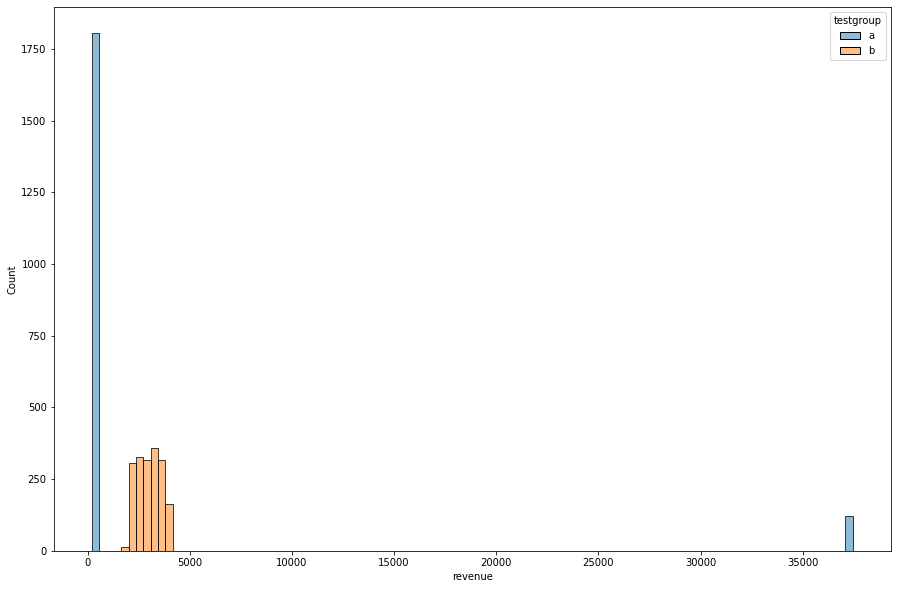

In [22]:
# построим график по платящим пользователям
plt.figure(figsize=(15,10))
sns.histplot(data = df[df['revenue'] != 0], x = 'revenue', hue = 'testgroup')
plt.show()

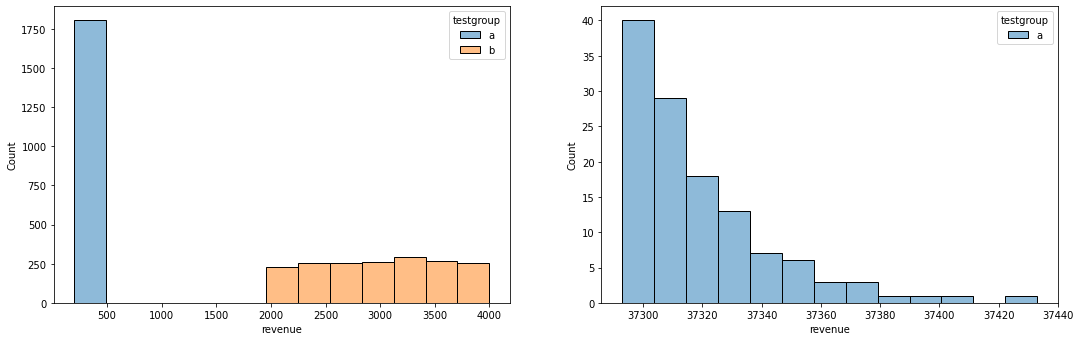

In [23]:
# из первого графика видно, что тестовая группа распределилась от 2000 до 5000, в то время как контрольная не превышает и 1000
# а также есть юзеры с выручкой более 35000
# построим два графика с выручкой больше 0 и до 5000 и второй с выручкой более 35000
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.histplot(data = df[(df['revenue'] > 0) & (df['revenue'] < 5000)], x = 'revenue', hue = 'testgroup')

plt.subplot(2, 2, 2)
sns.histplot(data = df[df['revenue'] > 35000], x = 'revenue', hue = 'testgroup')
plt.show()

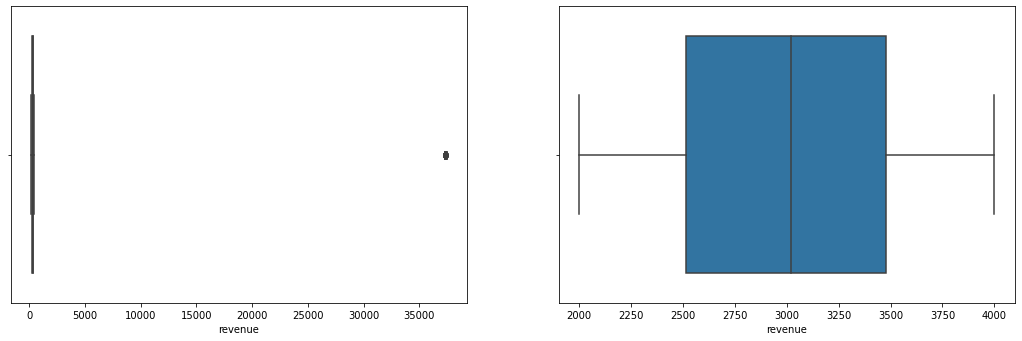

In [24]:
# построим боксплот, чтоб точно убедиться что правый график это выбросы,
# так как основная часть юзеров сконцентрировано на левом графике, 
# в это же время кол-во пользователей на правом графике не превышает и 40

plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.boxplot(data = df.query('testgroup == "a" and revenue > 0'), x = 'revenue')

plt.subplot(2, 2, 2)
sns.boxplot(data = df.query('testgroup == "b" and revenue > 0'), x = 'revenue')
plt.show()

### По боксплоту можно сделать вывод, что пользователи, которые принесли выручку > 35000 являются выбросами, а основная часть контрольной группы не привысила по выручке и 500, в то время как в тестовой группе выбросов нет и выручка лежит в диапазоне 2000-4000

### Теперь проведем статистические тесты, чтобы понять есть ли различия между группами по исследуемым метрикам
### Нормальность распределения данных проверим тестом Шапиро-Уилка, а равенство дисперсий при помощи теста Левена 

In [25]:
shapiro_a = sps.shapiro(df.query("testgroup == 'a'")['revenue'])
shapiro_b = sps.shapiro(df.query("testgroup == 'b'")['revenue'])

print(shapiro_a)
print(shapiro_b)

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)
ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [26]:
levene_test = sps.levene(df.query("testgroup == 'a'")['revenue'], df.query("testgroup == 'b'")['revenue'])

levene_test

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

## Результат теста на нормальность данных свидетельствует о том, что распределение данных НЕ является нормальным
## В таком случае необходимо применить непараметрический тест, как U-критерий Манна-Уитни, однако для выборок таких размеров допускается использование Т-теста. При сравнение метрик ARPU и ARPPU между контрольной и тестовой группой будем использовать его
## Для определения различия в конверсиях будем использовать Хи-Квадрат

### Проведем статистический тест, чтоб понять является ли разница ARPU в двух группах статистически значимой.
* Н0 - Разницы в ARPU между группами нет
* H1 - ARPU в тестовой группе значительно выше, чем в контрольной

In [28]:
a_arpu = df.query('testgroup == "a"')['revenue']
b_arpu = df.query('testgroup == "b"')['revenue']

t_stat, p_value = stats.ttest_ind(a_arpu, b_arpu, equal_var=False)  # Welch's t-test
t_stat, p_value 

(-0.6234876562792212, 0.5329647014130866)

### p-value > 0.05, соответсвенно мы не можем отвергнуть нулевую гипотезу, так как значение между группами статистически не значимо

### Проведем статистический тест, чтоб понять является ли разница ARPPU в двух группах статистически значимой.
* Н0 - Разницы в ARPPU между группами нет
* H1 - ARPPU в тестовой группе значительно выше, чем в контрольной

In [32]:
a_arppu = df.query('testgroup == "a" and revenue != 0')['revenue']
b_arppu = df.query('testgroup == "b" and revenue != 0')['revenue']

t_stat, p_value = stats.ttest_ind(a_arppu, b_arppu, equal_var=False)  # Welch's t-test
t_stat, p_value

(-1.6446302664300838, 0.10020780398916015)

### p-value > 0.05, соответсвенно мы не можем отвергнуть нулевую гипотезу, так как значение между группами статистически не значимо

### Проведем статистический тест, чтоб понять является ли разница CR в двух группах статистически значимой.
* Н0 - Разницы в CR между группами нет
* H1 - отличия есть

In [29]:
df['group'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)

In [30]:
df_crosstab = pd.crosstab(df['testgroup'], df['group'])
df_crosstab

group,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [31]:
stat, p_value, dof, expected = sps.chi2_contingency(df_crosstab)
stat, p_value

(4.374729521260405, 0.03647561892312613)

### p-value < 0.05, соответсвенно мы можем отвергнуть нулевую гипотезу и принять Н1

## Вывод
### При использовании t-test для сравнения метрик ARPU и ARPPU статистически значимых результатов не обнаружено, даже не смотря на то, что ARPU в тестовой группе на 5% оказалось выше. Также применный хи-квадрат позволил удостовериться, что CR в контрольной группе выше, чем в тестовой. В связи с этим рекомендуется не вносить изменения в продукт

### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

* DAU/MAU - данная метрика позволит оценить месячную активность пользователей во время ивента и когда ивент не проводился
* CR - конверсия участвующих игроков в ивенте, чтоб посмотреть сколько игроков приняло участие в ивенте от числа всех активных юзеров
* Retantion rate - как имзменилось удержание активных юзеров, например, по дням
* Churn rate - аналогично RR
* Среднее время нахождения в игре до и вовремя ивента
* Средний левл игроков - необходимо понимать насколько ценные призы и бонусы с увеличением уровня, готовы ли игроки качать свой левл (можно было бы сделать какую-нибудь аналогию с баттл пассом, чтоб не трогать основной уровень)
* При наличии системы pay-to-win или типа такого  можно оценить как вырос ARPPU, total revenue
* Оценить отношение положительных и отрицательных отзывов до и вовремя ивента
* Посмотреть изменилось ли количество установок приложений до и к концу ивента, где качают больше ios, android, steam и тп

#### При усложнении механик стоит обратить внимание на:
* Среднее количество попыток (например, неудачных)
* Оценить процент игроков дошедших до 5, 15, 30 и тд левела, узнать, где необходимо увеличить/уменьшить сложность
* Churn rate - много ли игроков бросали ивент/игру после неудачных попыток

### В целом набор метрик не изменится для оценки результата. Однако при втором варианте следует более внимательно сосредаточиться на удовлетворенности игроков и их возвращаемости в продукт, чтоб сложность не отпугнула основную аудиторию